In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from matplotlib.ticker import MaxNLocator

class_names = ["VEHICLE", "PEDESTRIAN", "CYCLIST"]


In [2]:
#Functions

def load_baseline(baseline_folder, log_file_idx=0):
    #load baseline
    #baseline_folder = "/home/cgriesbacher/thesis/3DTrans/output/avltruck_models/pvrcnnpp_ros/D6_50epochs/eval/epoch_50/val/zod"

    #log_file_idx = 0           #the selected eval is the first log file


    #get all files that start with "log"
    files = [f.path for f in os.scandir(baseline_folder) if f.name.startswith("log") ]
    files.sort()

    #select correct log file
    file = files[log_file_idx]

    with open(file) as f:
        lines = f.readlines()

    #get liens that start with any string in classes
    lines = [line for line in lines if line.startswith(tuple(class_names))]
    #check if there are any lines, if not, skip this file
    if len(lines) == 0:
        print("No lines starting with classes found, skipping file")

    #strip the lines
    lines = [line.strip() for line in lines]
    #remove the "\n"
    lines = [line.replace("\n", "") for line in lines]
    #split by ":" and keep second part
    values = [line.split(":")[1] for line in lines]
    #cast to float
    values = [float(line) for line in values]

    #split by "_" and keep first part
    classes = [line.split("_")[0] for line in lines]

    difficulties = [line.split("_")[1] for line in lines]
    #split by "/" and keep first part
    difficulties = [line.split("/")[0] for line in difficulties]

    metrics = [line.split("/")[1] for line in lines]
    metrics = [line.split(":")[0] for line in metrics]

    #convert to dataframe
    baseline_df = pd.DataFrame({"class": classes, "difficulty": difficulties, "metric": metrics, "value": values})

    return baseline_df

def load_data(folder):

    # get all subfolders, each subfoler is a different epoch
    epoch_folders = [f.path for f in os.scandir(folder) if f.is_dir() ]

    #remove folder that contains "eval_with_train"
    epoch_folders = [folder for folder in epoch_folders if "eval_with_train" not in folder]

    results_df = pd.DataFrame()
    for folder in epoch_folders:
        epoch_nr = folder.split("_")[-1]
        split_folder = [f.path for f in os.scandir(folder) if f.is_dir() ][0]
        eval_dataset_folder = [f.path for f in os.scandir(split_folder) if f.is_dir() ][0]
        #get all files that start with "log"
        files = [f.path for f in os.scandir(eval_dataset_folder) if f.name.startswith("log") ]
        files.sort()

        #load the last file as its the most recent one (regular text file)
        file = files[-1]

        with open(file) as f:
            lines = f.readlines()

        #get liens that start with any string in classes
        lines = [line for line in lines if line.startswith(tuple(class_names))]
        #check if there are any lines, if not, skip this file
        if len(lines) == 0:
            print("No lines starting with classes found, skipping file")

        #strip the lines
        lines = [line.strip() for line in lines]
        #remove the "\n"
        lines = [line.replace("\n", "") for line in lines]
        #split by ":" and keep second part
        values = [line.split(":")[1] for line in lines]
        #cast to float
        values = [float(line) for line in values]

        #split by "_" and keep first part
        classes = [line.split("_")[0] for line in lines]

        difficulties = [line.split("_")[1] for line in lines]
        #split by "/" and keep first part
        difficulties = [line.split("/")[0] for line in difficulties]

        metrics = [line.split("/")[1] for line in lines]
        metrics = [line.split(":")[0] for line in metrics]

        #convert to dataframe
        df = pd.DataFrame({"class": classes, "difficulty": difficulties, "metric": metrics, "value": values})
        #add epoch number
        df["epoch"] = int(epoch_nr)

        #concat to results_df
        results_df = pd.concat([results_df, df])

    return results_df

def plot_results(results_df, metric="AP", difficulty="2", draw_baseline=True, baseline_df=None, ax=None):

    #print difficutly 2 performance for each class over the epochs
    results_df = results_df[results_df["difficulty"] == difficulty]
    results_df = results_df[results_df["metric"] == metric]

    #if ax is not given, create new figure
    if ax is None:
        plt.figure(figsize=(10, 5))
        sns.set_theme(style="whitegrid")
        ax = plt.gca()
    
    sns.lineplot(data=results_df, x="epoch", y="value", hue="class", ax=ax)
    plt.title("Performance over epochs")
    plt.ylabel(metric+"/L"+difficulty,)
    plt.xlabel("Epoch")
    #set x ticks to integer and start at 1
    plt.xticks(np.arange(1, results_df["epoch"].max()+1, 1.0))    

    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    #add minor grid
    plt.grid(b=True, which='minor', linestyle='--', alpha=0.2)
    plt.minorticks_on()

    if draw_baseline and len(baseline_df) > 0:
        #add hline
        for i, class_name in enumerate(class_names):
            baseline_value = baseline_df[(baseline_df["class"] == class_name) & (baseline_df["difficulty"] == difficulty) & (baseline_df["metric"] == metric)]["value"].values[0]
            plt.axhline(y=baseline_value, linestyle='-', label="baseline "+class_name, ls="--", color=sns.color_palette()[i])

    #add legend outside of plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    #print highest performance for each class with  the corresponding epoch
    print("Highest performance for each class:")
    for class_name in class_names:
        max_value = results_df[results_df["class"] == class_name]["value"].max()
        max_epoch = results_df[results_df["value"] == max_value]["epoch"].values[0]
        print(class_name, ":", max_value, "at epoch", max_epoch)
        
    #return axis
    return ax



/tmp/ipykernel_394469/1828887342.py:130: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', linestyle='--', alpha=0.2)


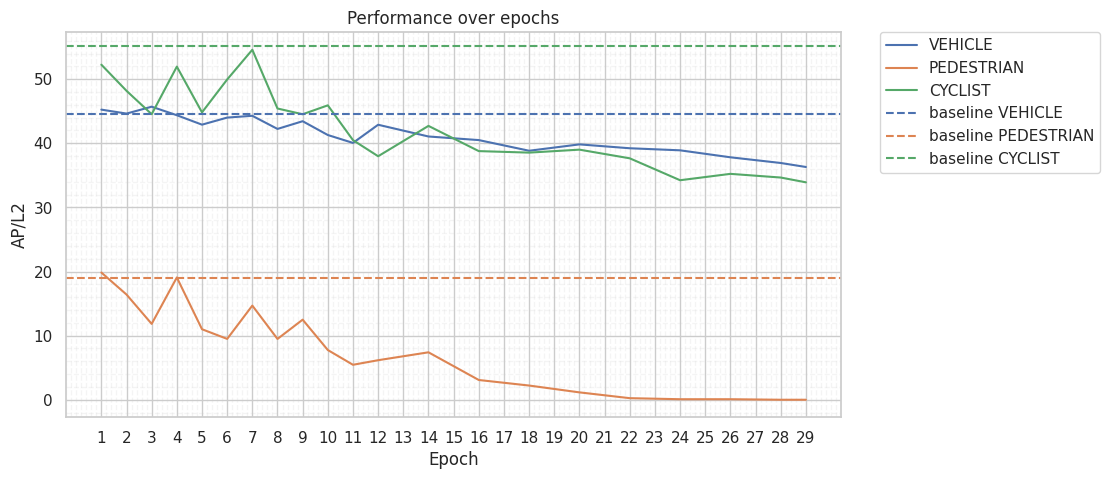

Highest performance for each class:
VEHICLE : 45.7102 at epoch 3
PEDESTRIAN : 19.8441 at epoch 1
CYCLIST : 54.5931 at epoch 7


In [15]:
#load baseline
baseline_folder = "/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp/D16_50epochs/eval/epoch_50/val/avltruck"

#convert to dataframe
baseline_df = load_baseline(baseline_folder, log_file_idx=0)

# Load data
folder = "/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp_ST++truck/D16_30epochs_STzod_ft_D6_50epochs_2/eval"
results_df = load_data(folder)

#plot results
draw_baseline = True
difficulty = "2"
metric = "AP"

ax = plot_results(results_df, baseline_df=baseline_df, metric=metric, difficulty=difficulty, draw_baseline=draw_baseline)


/tmp/ipykernel_23246/1828887342.py:130: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', linestyle='--', alpha=0.2)


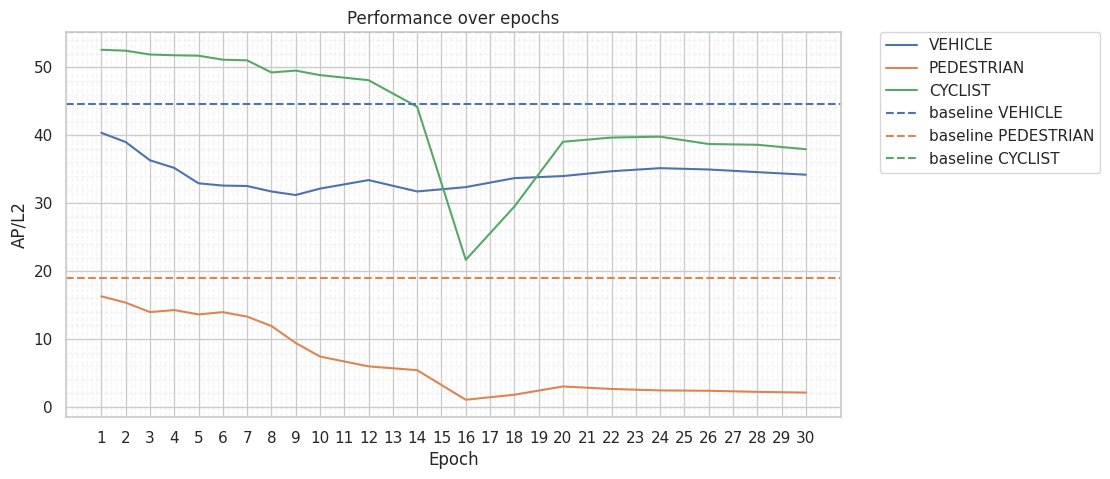

Highest performance for each class:
VEHICLE : 40.3698 at epoch 1
PEDESTRIAN : 16.2839 at epoch 1
CYCLIST : 52.6013 at epoch 1


In [10]:
#load baseline
baseline_folder = "/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp/D16_50epochs/eval/epoch_50/val/avltruck"

#convert to dataframe
baseline_df = load_baseline(baseline_folder, log_file_idx=0)

# Load data
folder = "/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp_ST++truck/D16_30epochs_STzod_ft_D6_50epochs_2/eval"
results_df = load_data(folder)

#plot results
draw_baseline = True
difficulty = "2"
metric = "AP"

ax = plot_results(results_df, baseline_df=baseline_df, metric=metric, difficulty=difficulty, draw_baseline=draw_baseline)